In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sbi.utils import BoxUniform
from torch.distributions.multivariate_normal import MultivariateNormal


from data.data_generators import SBIGaussian2d
from plot import plot_2d_pdf_on_grid, plot_2d_pdf_contours

from nde.flows import construct_maf
from nde.train import train

In [4]:
# SBI Task: Inference of 2d Gaussian Mean under uniform prior

# Prior
low_, high_ = -10, 10
prior = BoxUniform(
    low=torch.FloatTensor([low_, low_]), high=torch.FloatTensor([high_, high_])
)

# Data Generator
data_gen = SBIGaussian2d(prior=prior)

# Simulator
simulator = data_gen.simulator

In [10]:
# Generate data

# True distribution
theta_true = torch.FloatTensor([1,1])
# p(theta|x_0), x_0 ~ simulator(theta_true) 
x_obs = simulator(theta_true)
true_posterior_pdf = data_gen.true_posterior_pdf(x_obs)


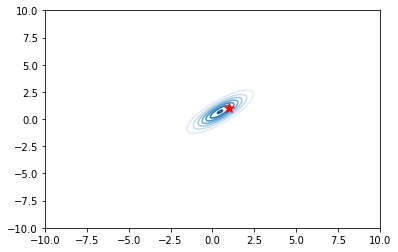

In [11]:
# Plot p(theta|x_0), x_0 ~ simulator(theta_true) 
plot_2d_pdf_on_grid(true_posterior_pdf, low_, high_, theta_true)

The simulator is stochastic, meaning that a generated observation `x_obs` might not correspond to the most probable one. In this case, the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ is centered around $x_0$=`x_obs`.

Indeed: $p(\theta \mid x_0) = p(x_0\mid \theta)p(\theta)$ with is maximal at $x_0 = \theta$ because $p(. \mid \theta) = \mathcal{N}(\theta, \Sigma)$ is maximal in it's mean.

In order to solve this stochasticity problem and get a posterior centered around the true parameters `theta_true` (i.e. that generated `x_obs`), we would need more than one observation giving an empirical approximation of the mean of the simulator likelihood $p(x\mid \theta_0) = \mathcal{N}(\mu,\Sigma)$ where $\mu = \theta_0$.



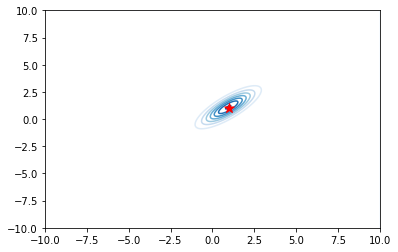

In [12]:
# p(theta|mean(x_1,...,x_10)), x_i ~ simulator(theta_true)
x_obs_100 = torch.stack([simulator(theta_true) for i in range(100)])
true_posterior_100_pdf = data_gen.true_posterior_pdf(x_obs_100)
# Plot p(theta|x_1,...,x_10), x_i ~ simulator(theta_true)
plot_2d_pdf_on_grid(true_posterior_100_pdf, low_, high_, theta_true)

In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0) = \mathcal{N}(x_0, \Sigma)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$

In [13]:
# Get train, val and test samples:
# - train samples are used to train the flow,
# - test samples are used to compute/learn the PIT-distribution

# Split in train/test sets (same as in code from paper)
train_size = 10_000  
theta_train, x_train = data_gen.get_joint_data(train_size)

print("NB training samples: ", x_train.shape[0])


NB training samples:  10000


In [14]:
# TRAIN FLOWS

# Good MAF...
maf_good = construct_maf(
    theta_train, hidden_features=50, context_features=2, standardize_transform=False
)

# ... trained on X=(X_1,X_2)
best_val_loss_good, epochs_good = train(
    maf_good,
    theta_train,
    context=x_train,  # X=(X_1,X_2)
    num_epochs=2000,
    batch_size=10,
    lr=0.005,
    validation=True,
    plot=False,
    epochs_until_converge=20,
)

# # Bad MAF...
# maf_bad = construct_maf(
#     theta_train, hidden_features=50, context_features=1, standardize_transform=False
# )

# # trained on g(X)=(X_1)
# g = first_dim_only
# best_val_loss_bad, epochs_bad = train(
#     maf_bad,
#     theta_train,
#     context=g(x_train),  # g(X)=(X_1)
#     num_epochs=2000,
#     batch_size=10,
#     lr=0.005,
#     validation=True,
#     plot=False,
#     epochs_until_converge=20,
# )

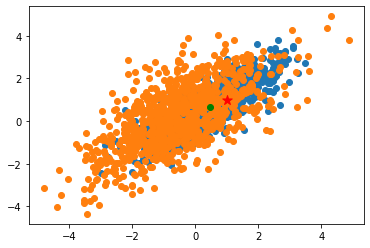

In [15]:
true_posterior = data_gen.true_posterior(x_obs)
true_posterior_samples = true_posterior.sample((1000,))
learned_posterior_samples = maf_good.sample(1000).detach().numpy()

plt.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1], label='true posterior')
plt.scatter(learned_posterior_samples[:,0],learned_posterior_samples[:,1], label='learned posterior')
plt.scatter(theta_true[0],theta_true[1], marker='*', s=100, color='red', label='theta_true')
plt.scatter(x_obs[0],x_obs[1], color='green', label='x_obs')
